You can download this post as a Juypter notebook [here](/posts/more-march-madness-monte-carlo-style.ipynb)

# MMMC the 2021 update

See the [original blog post](http://www.mglerner.com/blog/?p=16) for details and history. And the [2015 update](https://mglerner.github.io/posts/more-march-madness-monte-carlo-style.html) for ... the 2015 update. For this update (2021), I mainly just updated the code to deal with Python 3. Here's the short story: in my Statistical and Thermal Physics class, we want to use Monte Carlo simulations to generate brackets for March Madness. There are at least two obvious ways to go about this:

 1. Make some function that tells us the chance that team A beats team B, then flip coins for each matchup. That gets you one bracket. Repeat 100,000 times, collect statistics. This is the way Nate Silver's 538.com handles simulations for [basketball](https://projects.fivethirtyeight.com/2020-march-madness-predictions/), [elections](https://projects.fivethirtyeight.com/2020-election-forecast/), etc, and I should probably implement it (note to self/motivated students: it's as easy as just generating 100,000 new brackets at a given temperature).
 
 2. Generate one bracket, then do a Monte-Carlo walk through bracket space. This is tougher. We have to figure out how to make a move in bracket space, which is part of the fun of Monte Carlo simulations in general. To see how this is done, check out the code in `Bracket.swap` and `Brackets.simulate`.
 
As you can tell, we take option 2 above. Here's a walkthrough. First, load up our standard IPython setup

<!-- TEASER_END -->

In [1]:
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import HTML

## The basics

make me a single bracket at a given temperature

In [16]:
import imp
#import MarchMadnessMonteCarlo
#imp.reload(MarchMadnessMonteCarlo)
import MarchMadnessMonteCarlo as MMMC
imp.reload(MMMC)
teams = MMMC.regional_teams['south']
b = MMMC.Bracket(teams=teams,T=0.5)
print (b)

Baylor (1)                                                   
Hartford (16)             Bay (1)                            
North Carolina (8)                                           
Wisconsin (9)             Wis (9)  Bay (1)                   
Villanova (5)                                                
Winthrop (12)             Vil (5)                            
Purdue (4)                                                   
North Texas (13)          Pur (4)  Pur (4)  Bay (1)          
Texas Tech (6)            Uta (11) Ark (3)  Ark (3)  Ark (3) 
Utah St. (11)                                                
Arkansas (3)              Ark (3)                            
Colgate (14)                                                 
Florida (7)               Flo (7)  Flo (7)                   
Virginia Tech (10)                                           
Ohio St. (2)              Ora (15)                           
Oral Roberts (15)                                            
Total br

Now, instead of asking for all of the teams in the South, make up a set of Final Four teams, and run 1000 simulations. Show some statistics

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


Lowest energy bracket
Gonzaga (1)                                
Michigan (1)              Gon (1)          
Baylor (1)                Ill (1)  Gon (1) 
Illinois (1)                               
Total bracket energy: -0.2589999999999999

Most common bracket (228)
Gonzaga (1)                                
Michigan (1)              Gon (1)          
Baylor (1)                Ill (1)  Gon (1) 
Illinois (1)                               
Total bracket energy: -0.2589999999999999



/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Visualization.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplot2)


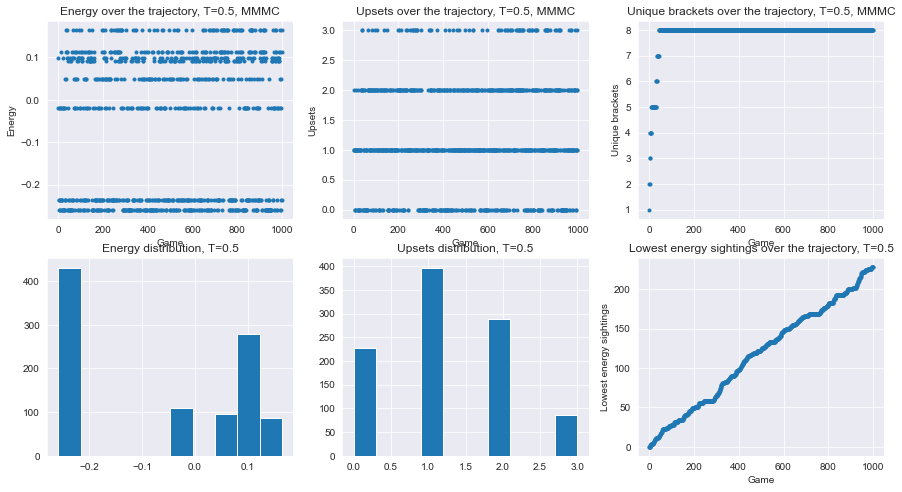

In [17]:
sr = MMMC.simulate(1000,['Gonzaga','Michigan','Baylor','Illinois'],0.5)
MMMC.showstats(sr,newfig=True)

As you can see, we fully sample bracket space pretty quickly (look at the graph in the top right, with the unique brackets shown).

# What should our temperature be?

If we had chosen option 1 at the top, we'd just flip coins with a given probability of winning. Here (and this may be a questionable decision), we need to set an overall temperature for our simulation. Intuitively, the higher the temperature, the closer we come to a random outcome. The lower the temperature, the closer we come to a "best seed always wins" bracket. If we're going to make sense of temperature, we should pick a reasonable energy function.

We can use [KenPom](http://www.kenpom.com)'s `log5` defined as

```python
def log5_energy_game(winner, loser):
    A,B = strength[winner],strength[loser]
    # see http://207.56.97.150/articles/playoff2002.htm
    win_pct = (A-A*B)/(A+B-2*A*B)
    return -win_pct
```

Conveniently, that's coded up for you in MarchMadnessMonteCarlo.examples.

Later on, we could make a fancy energy function with, e.g., a weighted average of KenPom, Jeff Sagarin, and the NCAA rankings. 

In [18]:
import MarchMadnessMonteCarlo.examples
MMMC.set_energy_function(MarchMadnessMonteCarlo.examples.default_energy_game)

Now, what should our actual temperature be? Historically, we know that an 8 seed vs. a 9 seed should essentially be a tossup. So, as a proxy here, we could just look at the chance of an 8 seed winning over a range of temperatures, and pick the point where it's pretty close to 0.5.

In [19]:
def winpct8(team8,team9,T,numtrials=10000):
    results = [MMMC.playgame(team8,team9,T)[0] == team8 for i in range(numtrials)]
    return np.average(results)
def plotwins(team8,team9,numtrials=10000,ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    Ts = np.linspace(0.001,3,100)
    pct = [winpct8(team8,team9,T,numtrials) for T in Ts]
    ax.plot(Ts,pct,label='{t1} vs. {t2}'.format(t1=team8,t2=team9))
    ax.set_xlabel('T')
    ax.set_ylabel('winpct')

We'll look at it for all four of the 8 vs. 9 matchups

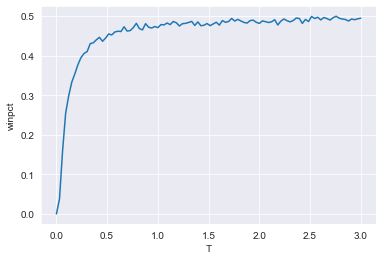

In [20]:
plotwins('North Carolina',"Wisconsin")

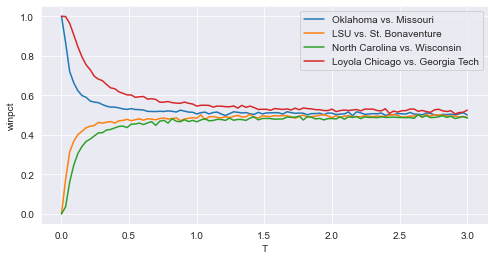

In [21]:
fig, ax = plt.subplots(figsize=(8,4))
plotwins('Oklahoma','Missouri',ax=ax)
plotwins('LSU','St. Bonaventure',ax=ax)
plotwins('North Carolina',"Wisconsin",ax=ax)
plotwins('Loyola Chicago','Georgia Tech',ax=ax)
plt.legend()

A couple of things jump out. First, the red and blue lines make sense: at very low temperatures, the higher-ranked team wins all the time. As temperature increases, unlikely outcomes become more likely.

The red and orange lines come from data in the real world: KenPom has the number 9 team ranked abouve the number 8 team. So the curve approaches 50% from below instead of from above.

Second, just eyeballing that, it looks like we could make a legitimate argument for almost anything between T=1 and 2. If you were looking at previous years, we're using a different energy function, so these numbers are a bit different this year.

What does that do to "clear" matchups? Well, Gonzaga is a big favorite over Villinova with this model:

In [22]:
MarchMadnessMonteCarlo.examples.default_energy_game('Gonzaga','Kansas')

-0.3117999999999999

In [ ]:
plotwins('Gonzaga','Kansas')

If I pick `T=1.0`, I get Gonzaga, the favorite, winning 55% of the time. You can feel free to choose a "more reasonable" temperature, but I'm rooting for KU here!

## Running some brackets!

So what does a bracket happen to look like? Well, in the original blog post, I mentioned that we came up with two different ways to run brackets. It can take a while to run a bracket, so a fast way (implemented as `runbracket2`) is to run separate brackets for each of the individual regions, then take the winner from each region's most common bracket to form a Final Four. Below, we do just that, running 10,000 trials for each of the regions, and 1000 trials for the Final Four.

In [ ]:
import imp
from MarchMadnessMonteCarlo import Brackets
imp.reload(Brackets)

In [23]:
results = MMMC.runbracket2(ntrials1=10000,ntrials2=1000,T=1.5)

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Brackets.py:62: RuntimeWarning: overflow encountered in exp
  boltzmann_factor = exp(-ediff/T)


YOUR LOWEST ENERGY BRACKETS
LOWEST ENERGY BRACKET FOR REGION midwest
Illinois (1)                                                 
Drexel (16)               Ill (1)                            
Loyola Chicago (8)                                           
Georgia Tech (9)          Loy (8)  Ill (1)                   
Tennessee (5)                                                
Oregon St. (12)           Ten (5)                            
Oklahoma St. (4)                                             
Liberty (13)              Okl (4)  Ten (5)  Ill (1)          
San Diego St. (6)         San (6)  San (6)  Hou (2)  Ill (1) 
Syracuse (11)                                                
West Virginia (3)         Wes (3)                            
Morehead St. (14)                                            
Clemson (7)               Rut (10) Hou (2)                   
Rutgers (10)                                                 
Houston (2)               Hou (2)                            
C

So, not looking so hot for my Kansas, but the code is working.

Let's visualize the results, then make a table of results, as per [538](http://fivethirtyeight.com/interactives/march-madness-predictions-2015/#mens).

/Users/mglerner/coding/IntroToStatMechAndThermal/OtherMonteCarlo/MMMC/MarchMadnessMonteCarlo/Visualization.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(subplot2)


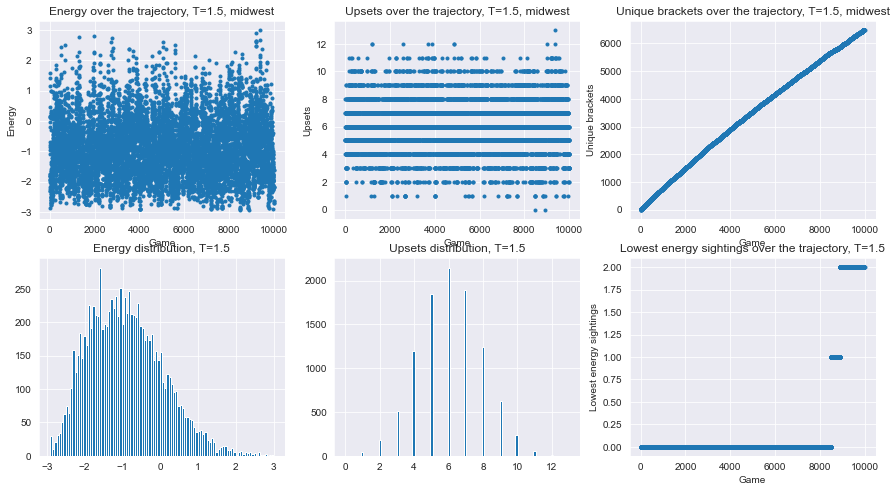

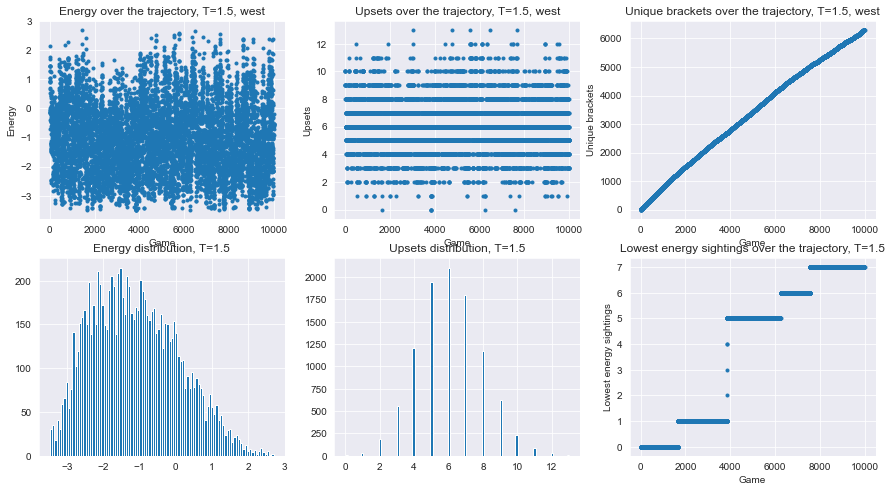

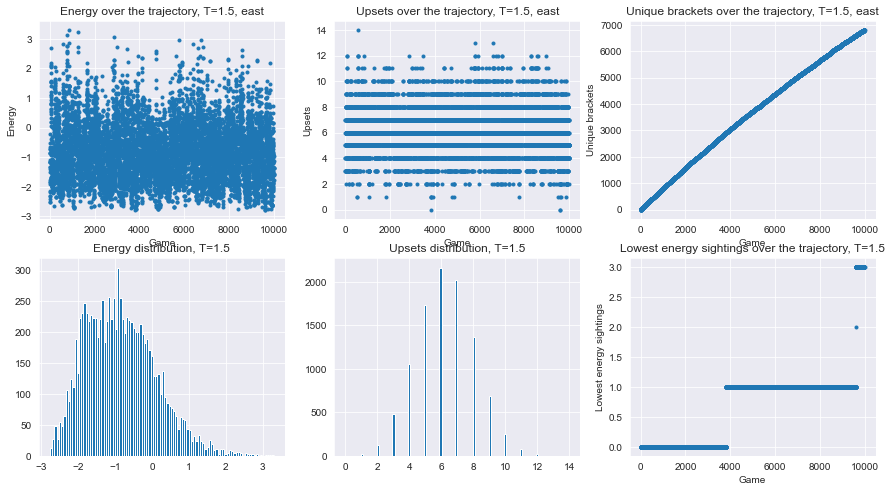

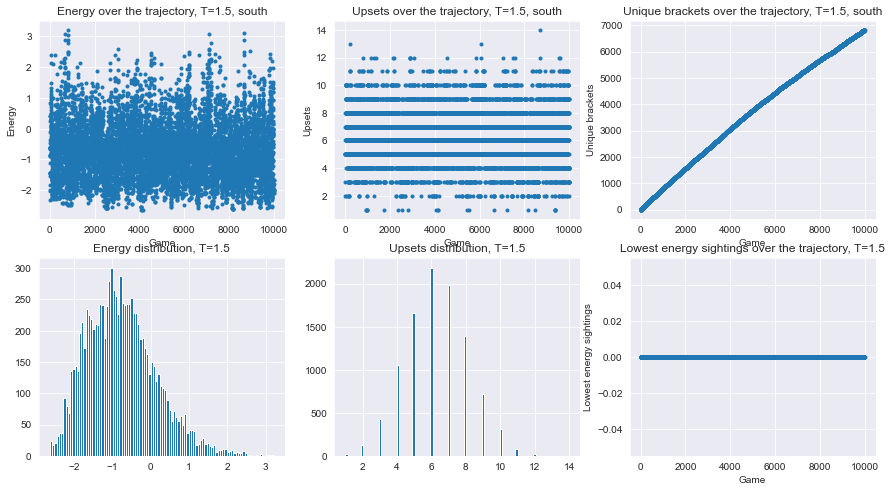

In [24]:
# Basic visualization
for region in 'midwest west east south'.split():
    MMMC.showstats(results[region],description=region,newfig=True)

Here you can see the classic reason to do Monte Carlo samping in the first place: we're absolutely nowhere near fully sampling bracket space. You can tell this from each of the "Unique brackets over the trajectory" plots, none of which have leveled out.

Further, you can see that the strength distribution in each of the regions is pretty different. Check out the energy distribution histograms for visual proof.

### Nice tables

And here's our set of tabulated results. Note that things look a little funny for the Final Four: `runbracket2` runs the final four separate from the rest of the tourney. So, only four teams are allowed to have Championship and Win percentages above zero (the final four percentages are taken from the first chunk of the tourney).

In [ ]:
imp.reload(Brackets)

In [ ]:
h = HTML(MMMC.maketable(results))
h

Given those concerns, let's just run `runbracket1` and look at the results

In [ ]:
results = MMMC.runbracket1(ntrials=10000,T=1.5)

In [ ]:
h = HTML(MMMC.maketable(results))
h

That is, indeed, high temperature! Let's try it with a bunch more runs

In [ ]:
results = MMMC.runbracket1(ntrials=100000,T=1.5)

In [ ]:
h = HTML(MMMC.maketable(results))
h

In [ ]:
MMMC.showstats(results['all'],description='full run',newfig=True)

Not bad! (Also, note the shape of the energy distribution, and the fact taht the "Unique brackets" group is still basically linear!)

## Who wins?

But let's be honest for a minute. We all know Kansas is going to win. What do the brackets where that happened look like?

In [ ]:
goodbrackets = [i for i in results['all'].brackets if i.bracket[-1][0] == 'Kansas']

In [ ]:
imp.reload(MarchMadnessMonteCarlo)

In [ ]:
from MarchMadnessMonteCarlo.Brackets import Stats
lb, mcb, mcb_count, unique_brackets, lowest_sightings = Stats.gather_uniquestats(goodbrackets)
sr = MMMC.SimulationResults(goodbrackets,unique_brackets,lb,lowest_sightings,mcb,mcb_count)
trueresults = {'all':sr}

In [ ]:
h = HTML(MMMC.maketable(trueresults))
h

In [ ]:
sr.most_common_bracket

In [ ]:
sr.most_common_bracket_count

Huh. Well, that's not exactly my pick for best bracket, but there you have it.

Excersizes for the reader:

 * make a better energy function, using maybe a weighted average of different rankings. I slurped in KenPom and Jeff Sagarin, but you could add your own. 
 * come up with a better "hometown wins" version. E.g. explicitly check for KU, and tweak the rankings.

In [ ]:
from MarchMadnessMonteCarlo import RankingsAndStrength as RAS
strength = RAS.kenpom['Pyth']
jsstrength = RAS.sagarin['Rating']

def weighted_KU_energy_game(winner, loser):
    if winner == 'Kansas':
        win_pct = 0.99
    elif loser == 'Kansas':
        win_pct = 0.01
    else:
        A,B = strength[winner],strength[loser]
        # see http://207.56.97.150/articles/playoff2002.htm
        kenpom = (A-A*B)/(A+B-2*A*B)
        A,B = jsstrength[winner]/100, jsstrength[loser]/100
        A,B = min(A,0.9999),min(B,0.9999)
        sagarin = (A-A*B)/(A+B-2*A*B)
        win_pct = 0.70*kenpom + 0.30*sagarin
    return -win_pct


In [ ]:
MMMC.set_energy_function(weighted_KU_energy_game)

In [ ]:
results = MMMC.runbracket1(ntrials=100000,T=1.5)

In [ ]:
MMMC.showstats(results['all'],description='full run',newfig=True)

In [ ]:
h = HTML(MMMC.maketable(results))
h

Looks good! I'm in!